# Invaraint VAE training

In [1]:
%load_ext autoreload
%autoreload 2

import os


os.environ["WANDB_NOTEBOOK_NAME"] = "inv_vae.ipynb"
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"
# XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

from itertools import product
from pathlib import Path

import ciclo
import flax
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import wandb
from absl import logging
from clu import deterministic_data
from jax.config import config as jax_config
from ml_collections import config_dict

from experiments.utils import load_checkpoint, save_checkpoint
from src.models.inv_vae import (
    INV_VAE,
    create_inv_vae_state,
    make_inv_vae_plotting_fns,
    make_inv_vae_train_and_eval,
)
from src.models.transformation_generative_model import (
    TransformationGenerativeNet,
    create_transformation_generative_state,
    make_transformation_generative_train_and_eval,
)
from src.models.transformation_inference_model import (
    TransformationInferenceNet,
    create_transformation_inference_state,
    make_transformation_inference_train_and_eval,
)
from src.models.utils import reset_metrics
from src.utils.gen_plots import plot_gen_dists, plot_gen_model_training_metrics
from src.utils.input import get_data
from src.utils.proto_plots import (
    make_get_prototype_fn,
    plot_proto_model_training_metrics,
    plot_protos_and_recons,
)
from src.utils.training import custom_wandb_logger
from experiments.configs.inf_best import get_config as get_inf_config
from experiments.configs.gen_best import get_config as get_gen_config
from experiments.configs.vae_mnist import get_config as get_vae_config

flax.config.update("flax_use_orbax_checkpointing", True)
logging.set_verbosity(logging.INFO)
plt.rcParams["savefig.facecolor"] = "white"


/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I0000 00:00:1704633743.854766 3039744 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
ANGLE = 180
inf_config = get_inf_config(f"MNIST,0,{ANGLE},50000")
gen_config = get_gen_config(f"MNIST,0,{ANGLE},50000")
vae_config = get_vae_config(f"{ANGLE}")

In [3]:
inf_config.checkpoint = f"ckpts/inf_mnist_{ANGLE}"
gen_config.checkpoint = f"ckpts/gen_mnist_{ANGLE}"
# vae_config.checkpoint = f"ckpts/vae_mnist_{ANGLE}"

## Train Inf

In [4]:
rng = random.PRNGKey(inf_config.seed)
data_rng, init_rng = random.split(rng)

In [5]:
train_ds, val_ds, _ = get_data(inf_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _

In [6]:
inf_model = TransformationInferenceNet(
    bounds=inf_config.get("augment_bounds", None),
    offset=inf_config.get("augment_offset", None),
    **inf_config.model.to_dict(),
)

inf_state = create_transformation_inference_state(
    inf_model, inf_config, init_rng, input_shape
)

INFO:absl:
+--------------------------------+--------------+-----------+-----------+--------+
| Name                           | Shape        | Size      | Mean      | Std    |
+--------------------------------+--------------+-----------+-----------+--------+
| params/Dense_0/bias            | (5,)         | 5         | 0.0       | 0.0    |
| params/Dense_0/kernel          | (256, 5)     | 1,280     | 0.0       | 0.0    |
| params/MLP_0/Dense_0/bias      | (2048,)      | 2,048     | 0.0       | 0.0    |
| params/MLP_0/Dense_0/kernel    | (784, 2048)  | 1,605,632 | 1.81e-05  | 0.0357 |
| params/MLP_0/Dense_1/bias      | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/MLP_0/Dense_1/kernel    | (2048, 1024) | 2,097,152 | 4.55e-07  | 0.0221 |
| params/MLP_0/Dense_2/bias      | (512,)       | 512       | 0.0       | 0.0    |
| params/MLP_0/Dense_2/kernel    | (1024, 512)  | 524,288   | -3.06e-05 | 0.0312 |
| params/MLP_0/Dense_3/bias      | (256,)       | 256       | 0.0       | 0.

In [7]:
inf_model_checkpoint_path = inf_config.get("checkpoint", "")
if (
    inf_model_checkpoint_path != ""
    and not Path(inf_model_checkpoint_path).exists()
):    
    run = wandb.init(
        project="iclr2024experiments",
        entity="invariance-learners",
        config=inf_config.to_dict(),
        mode="offline",
        notes="",
        name=None,
        settings=wandb.Settings(code_dir="../"),
    )
    
    train_step, eval_step = make_transformation_inference_train_and_eval(
        inf_model, inf_config
    )

    inf_final_state, history, _ = ciclo.train_loop(
        inf_state,
        deterministic_data.start_input_pipeline(train_ds),
        {
            ciclo.on_train_step: [train_step],
            ciclo.on_reset_step: reset_metrics,
            ciclo.on_test_step: eval_step,
        },
        test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
        epoch_duration=int(inf_config.steps * inf_config.eval_freq),
        callbacks=[
            ciclo.keras_bar(total=inf_config.steps),
        ],
        stop=inf_config.steps + 1,
    )

    save_checkpoint(inf_model_checkpoint_path, inf_final_state, inf_config)

    fig = plot_proto_model_training_metrics(history)
    run.summary["proto_training_metrics"] = wandb.Image(fig)
    plt.close(fig)
         
    run.finish()
else:
    inf_final_state, _ = load_checkpoint(
        inf_model_checkpoint_path, inf_state, inf_config
    )

INFO:absl:Loading model checkpoint from ckpts/inf_mnist_180.
INFO:absl:OCDBT is initialized successfully.
INFO:absl:Restoring item from ckpts/inf_mnist_180.
INFO:absl:Finished restoring checkpoint from ckpts/inf_mnist_180.
Loaded config:
angle: 180.0
augment_bounds:
- 0.25
- 0.25
- 3.141592653589793
- 0.25
- 0.25
augment_offset:
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
batch_size: 512
blur_end_pct: 0.01
blur_filter_size: 5
"blur_\u03C3_init": 0.0
checkpoint: ckpts/inf_mnist_180
clip_norm: 10.0
dataset: MNIST
eval_freq: 0.01
final_lr_mult: 0.001
init_lr_mult: 0.03
interpolation_order: 3
invertibility_loss_mult: 0.1
lr: 0.0003
model:
  hidden_dims:
  - 2048
  - 1024
  - 512
  - 256
  squash_to_bounds: false
model_name: inference_net
n_samples: 5
num_trn: 50000
num_val: 10000
pp_eval: value_range(-1, 1)|random_rotate(-180.0, 180.0, fill_value=-1)|keep(["image",
  "label"])
pp_train: value_range(-1, 1)|random_rotate(-180.0, 180.0, fill_value=-1)|keep(["image",
  "label"])
repeat_after_batching: true


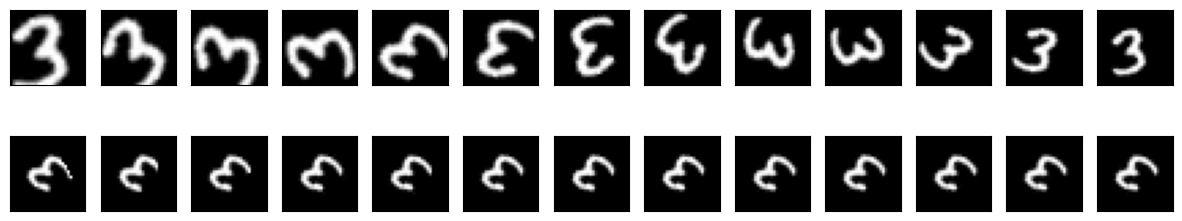

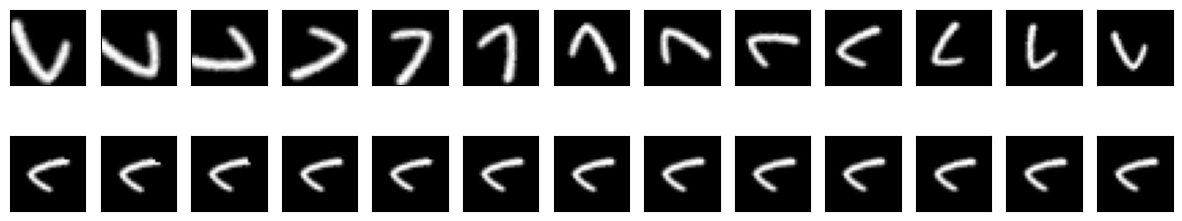

In [8]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

get_prototype = make_get_prototype_fn(
    inf_model,
    inf_final_state,
    rng,
    inf_model.transform,
    inf_config.get("transform_kwargs", None),
)

for i, (x_, mask) in enumerate(
    product(
        [
            val_batch["image"][0][14],
            val_batch["image"][0][12],
            # val_batch["image"][0][1],
            # val_batch["image"][0][4],
            # val_batch["image"][0][9],
        ],
        [
            # jnp.array([0, 0, 1, 0, 0]),
            # jnp.array([1, 1, 0, 0, 0]),
            jnp.array([1, 1, 1, 1, 1]),
        ],
    )
):
    fig = plot_protos_and_recons(
        x_, jnp.array(inf_config.augment_bounds) * mask, inf_model.transform, get_prototype, inf_config.get("transform_kwargs", None),
    )
    try:
        run.summary[f"inf_plots_{i}"] = wandb.Image(fig)
    except:
        pass
    plt.show(fig)
    plt.close(fig)

## Train Gen

In [9]:
def prototype_function(x, rng):
    η = inf_model.apply(
        {"params": inf_final_state.params}, x, train=False
    ).sample(seed=rng)
    return η

In [10]:
rng = random.PRNGKey(gen_config.seed)
data_rng, init_rng = random.split(rng)

In [11]:
train_ds, val_ds, _ = get_data(gen_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'labe

INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]', 'label': 'int64[]'}


In [12]:
gen_model = TransformationGenerativeNet(
    bounds=gen_config.get("augment_bounds", None),
    offset=gen_config.get("augment_offset", None),
    **gen_config.model.to_dict(),
)

gen_state = create_transformation_generative_state(
    gen_model,
    gen_config,
    init_rng,
    input_shape,
)

INFO:absl:
+----------------------------------------------+-------------+---------+-----------+--------+
| Name                                         | Shape       | Size    | Mean      | Std    |
+----------------------------------------------+-------------+---------+-----------+--------+
| params/Conditioner_0/Dense_0/bias            | (95,)       | 95      | 0.0       | 0.0    |
| params/Conditioner_0/Dense_0/kernel          | (256, 95)   | 24,320  | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/Dense_0/bias      | (256,)      | 256     | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/Dense_0/kernel    | (261, 256)  | 66,816  | 0.000127  | 0.0618 |
| params/Conditioner_0/MLP_0/LayerNorm_0/bias  | (256,)      | 256     | 0.0       | 0.0    |
| params/Conditioner_0/MLP_0/LayerNorm_0/scale | (256,)      | 256     | 1.0       | 0.0    |
| params/Conditioner_1/Dense_0/bias            | (95,)       | 95      | 0.0       | 0.0    |
| params/Conditioner_1/Dense_0/kernel          | 

In [13]:
gen_model_checkpoint_path = gen_config.get("checkpoint", "")
if (
    gen_model_checkpoint_path != ""
    and not Path(gen_model_checkpoint_path).exists()
):
    run = wandb.init(
        project="iclr2024experiments",
        entity="invariance-learners",
        config=gen_config.to_dict(),
        mode="offline",
        notes="",
        name=None,
        settings=wandb.Settings(code_dir="../"),
    )

    train_step, eval_step = make_transformation_generative_train_and_eval(
        gen_model, gen_config, prototype_function=prototype_function
    )

    gen_final_state, history, _ = ciclo.train_loop(
        gen_state,
        deterministic_data.start_input_pipeline(train_ds),
        {
            ciclo.on_train_step: [train_step],
            ciclo.on_reset_step: reset_metrics,
            ciclo.on_test_step: eval_step,
        },
        test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
        epoch_duration=int(gen_config.steps * gen_config.eval_freq),
        callbacks=[
            ciclo.keras_bar(total=gen_config.steps),
        ],
        stop=gen_config.steps + 1,
    )

    save_checkpoint(gen_model_checkpoint_path, gen_final_state, gen_config)

    fig = plot_gen_model_training_metrics(history)
    run.summary[f"gen_training_metrics"] = wandb.Image(fig)
    plt.close(fig)

    run.finish()
else:
    gen_final_state, _ = load_checkpoint(
        gen_model_checkpoint_path, gen_state, gen_config
    )

INFO:absl:Loading model checkpoint from ckpts/gen_mnist_180.
INFO:absl:Restoring item from ckpts/gen_mnist_180.
INFO:absl:Finished restoring checkpoint from ckpts/gen_mnist_180.
Loaded config:
angle: 180.0
augment_bounds:
- 0.25
- 0.25
- 3.141592653589793
- 0.25
- 0.25
augment_offset:
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
batch_size: 512
checkpoint: ckpts/gen_mnist_180
clip_norm: 2.0
dataset: MNIST
eval_freq: 0.01
final_lr_mult: 0.03
init_lr_mult: 0.1
interpolation_order: 3
lr: 0.003
mae_loss_mult: 1.0
model:
  conditioner:
    dropout_rate: 0.1
    hidden_dims:
    - 256
  dropout_rate: 0.2
  hidden_dims:
  - 1024
  - 512
  - 256
  num_bins: 6
  num_flows: 6
  squash_to_bounds: false
model_name: generative_net
n_samples: 5
num_trn: 50000
num_val: 10000
pp_eval: value_range(-1, 1)|random_rotate(-180.0, 180.0, fill_value=-1)|keep(["image",
  "label"])
pp_train: value_range(-1, 1)|random_rotate(-180.0, 180.0, fill_value=-1)|keep(["image",
  "label"])
repeat_after_batching: true
seed: 0
shuffle: 

2024-01-07 13:23:00.847598: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


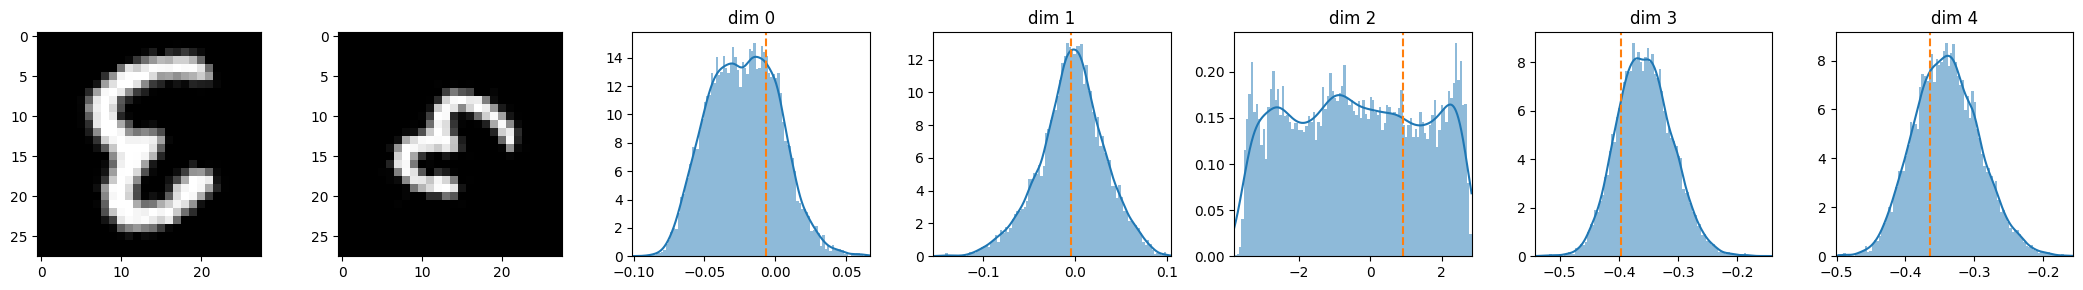

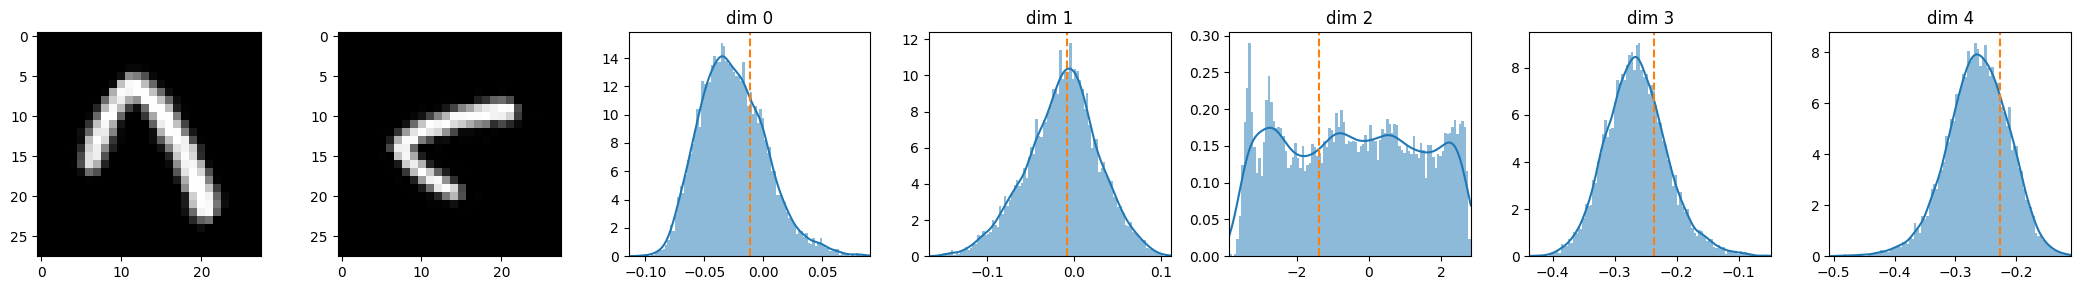

In [14]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)
for i, x in enumerate(
    [
        val_batch["image"][0][14],
        val_batch["image"][0][12],
        # val_batch["image"][0][1],
        # val_batch["image"][0][4],
        # val_batch["image"][0][9],
    ]
):
    fig = plot_gen_dists(
        x,
        prototype_function,
        rng,
        gen_model,
        gen_final_state.params,
        gen_config,
    )
    try:
        run.summary[f"gen_plots_{i}"] = wandb.Image(fig)
    except:
        pass
    plt.show(fig)
    plt.close(fig)

## Train AUG-VAE

In [15]:
rng = random.PRNGKey(vae_config.seed)
data_rng, init_rng = random.split(rng, 2)

In [16]:
train_ds, val_ds, test_ds = get_data(vae_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

In [17]:
inv_vae_model = INV_VAE(
    transform=gen_model.transform,
    transform_kwargs=gen_config.get("transform_kwargs", None),
    vae=vae_config.model.to_dict(),
    inference=inf_config.model.to_dict(),
    generative=gen_config.model.to_dict(),
    bounds=gen_config.get("augment_bounds", None),
    offset=gen_config.get("augment_offset", None),
)

inv_vae_state = create_inv_vae_state(
    inv_vae_model,
    vae_config,
    init_rng,
    input_shape,
    inf_final_state,
    gen_final_state,
)

INFO:absl:
+------------------------------------------------------+------------------+-----------+-----------+----------+
| Name                                                 | Shape            | Size      | Mean      | Std      |
+------------------------------------------------------+------------------+-----------+-----------+----------+
| params/inference_model/Dense_0/bias                  | (5,)             | 5         | 0.0       | 0.0      |
| params/inference_model/Dense_0/kernel                | (256, 5)         | 1,280     | 0.0       | 0.0      |
| params/inference_model/MLP_0/Dense_0/bias            | (2048,)          | 2,048     | 0.0       | 0.0      |
| params/inference_model/MLP_0/Dense_0/kernel          | (784, 2048)      | 1,605,632 | 2.95e-05  | 0.0358   |
| params/inference_model/MLP_0/Dense_1/bias            | (1024,)          | 1,024     | 0.0       | 0.0      |
| params/inference_model/MLP_0/Dense_1/kernel          | (2048, 1024)     | 2,097,152 | 2e-05     | 0

In [18]:
train_step, eval_step = make_inv_vae_train_and_eval(inv_vae_model, vae_config)
x = next(deterministic_data.start_input_pipeline(val_ds))["image"][0]
reconstruction_plot, sampling_plot = make_inv_vae_plotting_fns(
    vae_config, inv_vae_model, x
)

2024-01-07 13:24:15.179962: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


    0/10000 [..............................] - ETA: 0s - elbo: -1462.8459 - iwlb: nan - kld: 0.0000e+00 - ll: -1462.8459 - loss: 1462.8459 - x_mse: 0.8508 - elbo_test: -1436.4243 - iwlb_test: nan - kld_test: 2.2911e-04 - ll_test: -1436.4238 - loss_test: 1436.4243 - x_mse_test: 1.3161

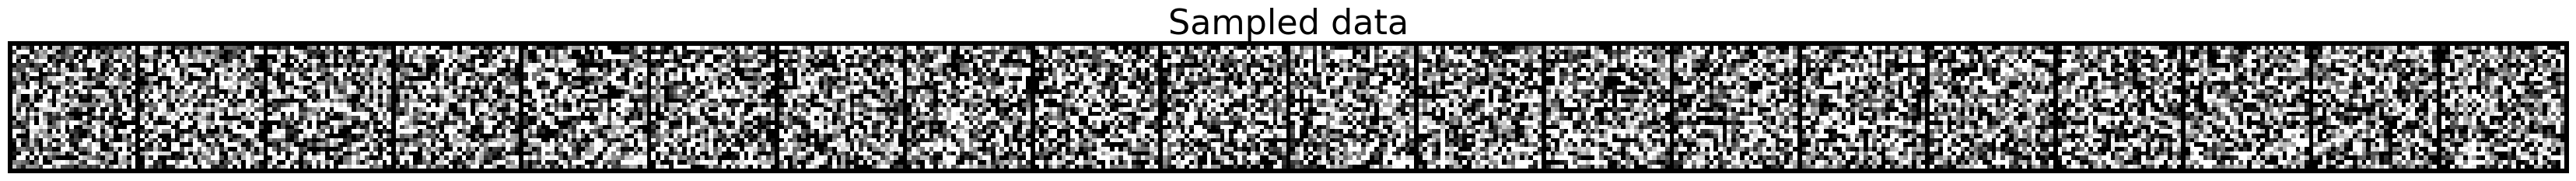

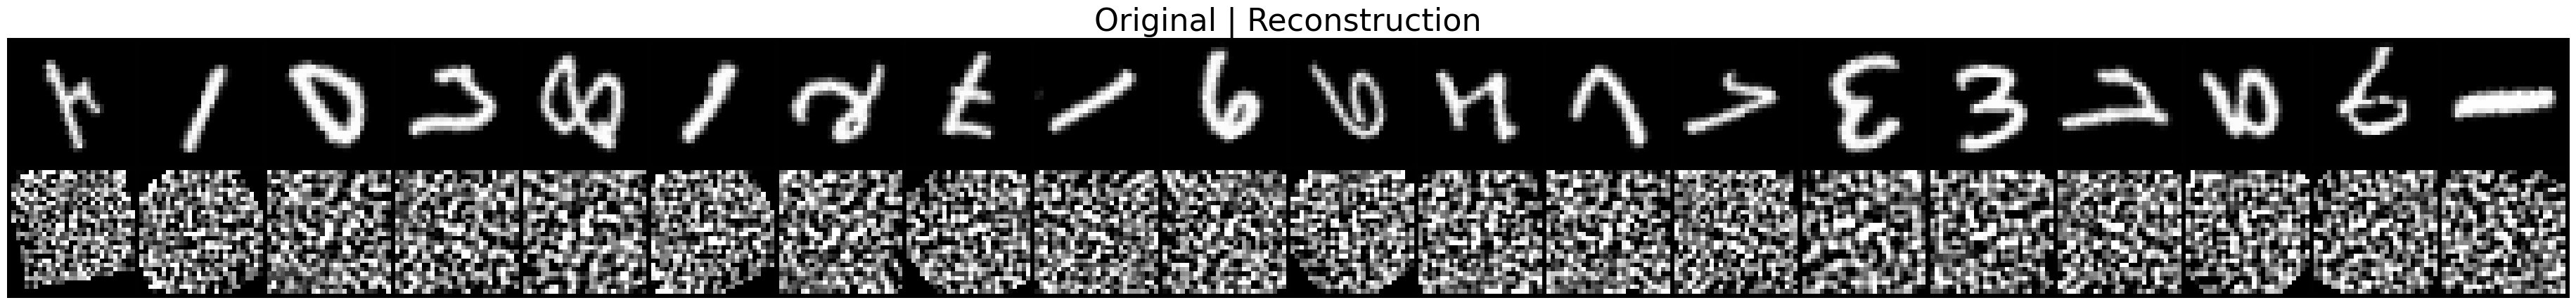

 2500/10000 [======>.......................] - ETA: 11:13 - elbo: -67.4908 - iwlb: nan - kld: 21.2182 - ll: -46.2726 - loss: 67.4908 - x_mse: 0.0261 - elbo_test: -52.4704 - iwlb_test: nan - kld_test: 21.8548 - ll_test: -30.6157 - loss_test: 52.4704 - x_mse_test: 0.0273               1   - ETA: 22:21:20 - elbo: -1398.4586 - iwlb: nan - kld: 0.0032 - ll: -1398.4554 - loss: 1398.4586 - x_mse: 1.2296 - elbo_test: -1436.4243 - iwlb_test: nan - kld_test: 2.2911e-04 - ll_test: -1436.4238 - loss_test: 1436.4243 - x_mse_test:  - ETA: 12:28:26 - elbo: -1356.9830 - iwlb: nan - kld: 0.0111 - ll: -1356.9722 - loss: 1356.9830 - x_mse: 1.1458 - elbo_test: -1436.4243 - iwlb_test: nan - kld_test: 2.2911e-04 - ll_test: -1436.4238 - loss_test: 1436.4243 - x_mse_test: 1.31 - ETA: 11:14:22 - elbo: -1346.6793 - iwlb: nan - kld: 0.0141 - ll: -1346.6654 - loss: 1346.6793 - x_mse: 1.1253 - elbo_test: -1436.4243 - iwlb_test: nan - kld_test: 2.2911e-04 - ll_test: -1436.4238 - loss_test: 1436.4243 - x_mse_test: 1

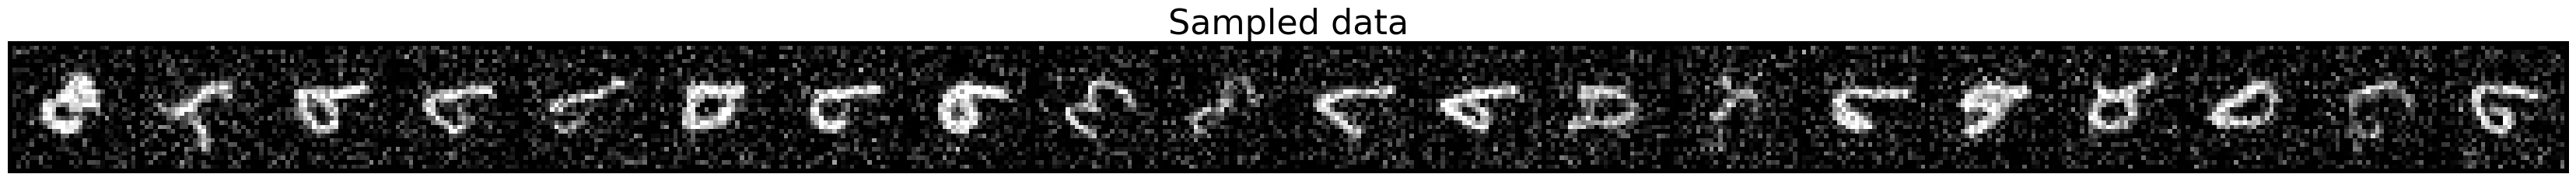

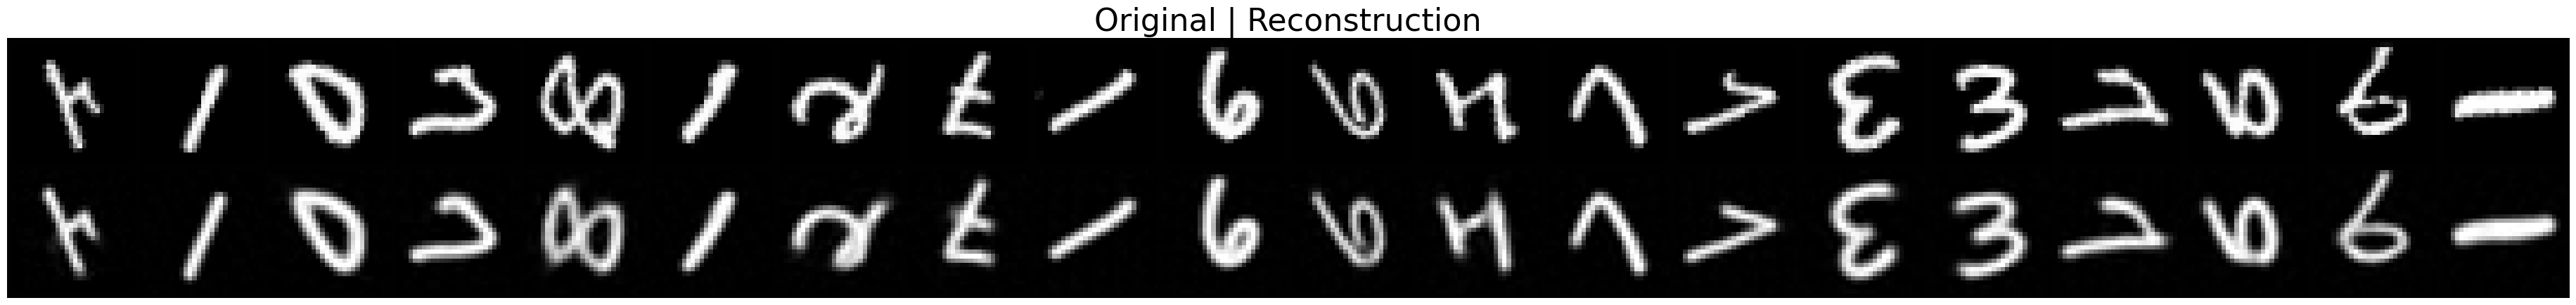

 5000/10000 [==============>...............] - ETA: 6:54 - elbo: 541.3574 - iwlb: nan - kld: 33.4313 - ll: 574.7889 - loss: -541.3574 - x_mse: 0.0160 - elbo_test: 535.3627 - iwlb_test: nan - kld_test: 33.5872 - ll_test: 568.9500 - loss_test: -535.3627 - x_mse_test: 0.0186 A: 11:25 - elbo: -48.5826 - iwlb: nan - kld: 21.5068 - ll: -27.0758 - loss: 48.5826 - x_mse: 0.0256 - elbo_test: -52.4704 - iwlb_test: nan - kld_test: 21.8548 - ll_test: -30.6157 - loss_test: 52.4704 - x_mse_test: 0.0 - ETA: 11:24 - elbo: -47.6652 - iwlb: nan - kld: 21.4832 - ll: -26.1820 - loss: 47.6652 - x_mse: 0.0254 - elbo_test: -52.4704 - iwlb_test: nan - kld_test: 21.8548 - ll_test: -30.6157 - loss_test: 52.4704 - x_mse_test: 0.0 - ETA: 11:23 - elbo: -47.0476 - iwlb: nan - kld: 21.5986 - ll: -25.4490 - loss: 47.0476 - x_mse: 0.0254 - elbo_test: -52.4704 - iwlb_test: nan - kld_test: 21.8548 - ll_test: -30.6157 - loss_test: 52.4704 - x_mse_test: 0.02 - ETA: 11:22 - elbo: -46.7298 - iwlb: nan - kld: 21.6357 - ll: -

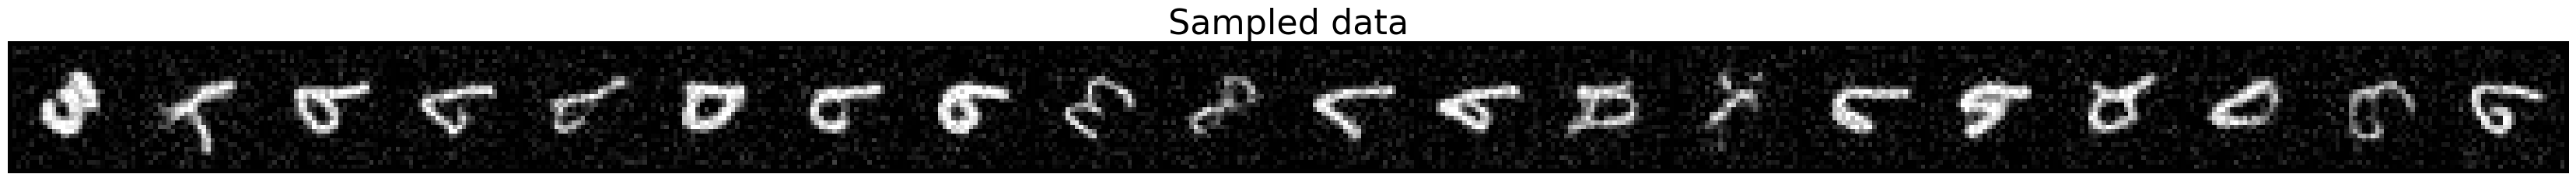

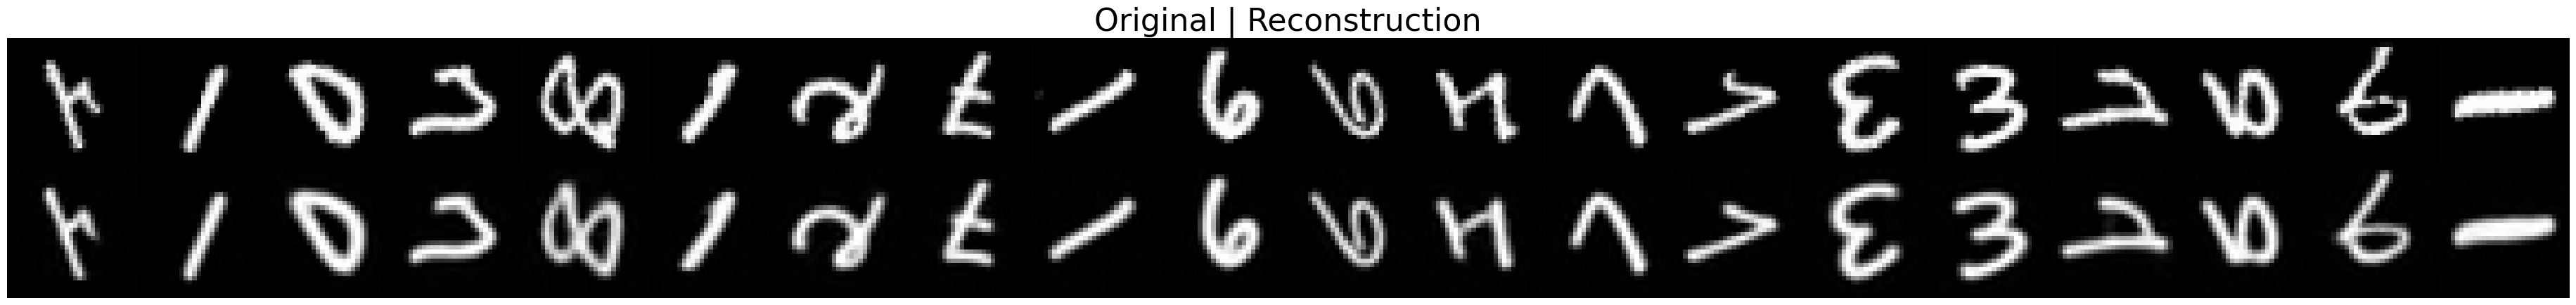

 7500/10000 [=====================>........] - ETA: 3:22 - elbo: 926.6299 - iwlb: nan - kld: 39.1306 - ll: 965.7605 - loss: -926.6299 - x_mse: 0.0140 - elbo_test: 896.4114 - iwlb_test: nan - kld_test: 39.3394 - ll_test: 935.7509 - loss_test: -896.4114 - x_mse_test: 0.0173 ETA: 6:58 - elbo: 547.8241 - iwlb: nan - kld: 33.8226 - ll: 581.6467 - loss: -547.8241 - x_mse: 0.0166 - elbo_test: 535.3627 - iwlb_test: nan - kld_test: 33.5872 - ll_test: 568.9500 - loss_test: -535.3627 - x_mse_test: 0.01 - ETA: 6:57 - elbo: 548.0150 - iwlb: nan - kld: 33.8838 - ll: 581.8987 - loss: -548.0150 - x_mse: 0.0165 - elbo_test: 535.3627 - iwlb_test: nan - kld_test: 33.5872 - ll_test: 568.9500 - loss_test: -535.3627 - x_mse_test: 0. - ETA: 6:57 - elbo: 547.9830 - iwlb: nan - kld: 33.8300 - ll: 581.8130 - loss: -547.9830 - x_mse: 0.0166 - elbo_test: 535.3627 - iwlb_test: nan - kld_test: 33.5872 - ll_test: 568.9500 - loss_test: -535.3627 - x_mse_test: 0. - ETA: 6:57 - elbo: 548.9245 - iwlb: nan - kld: 33.7566

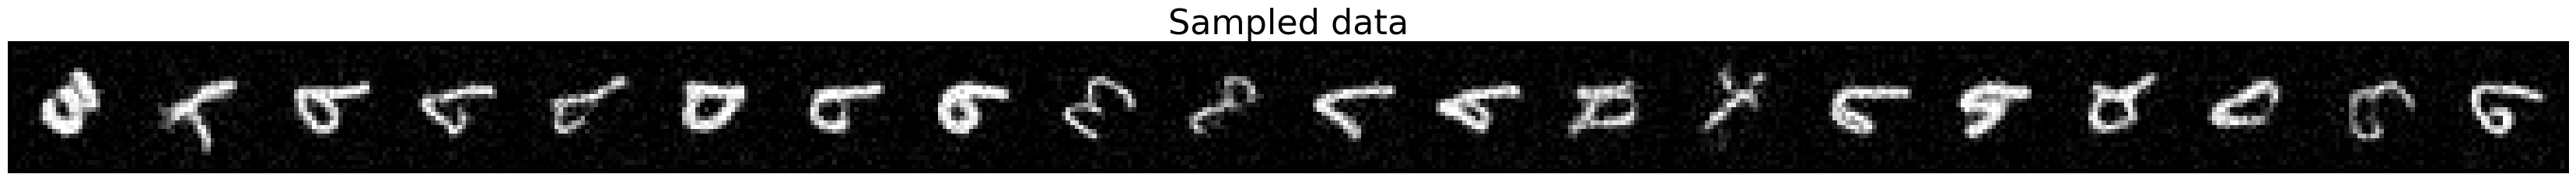

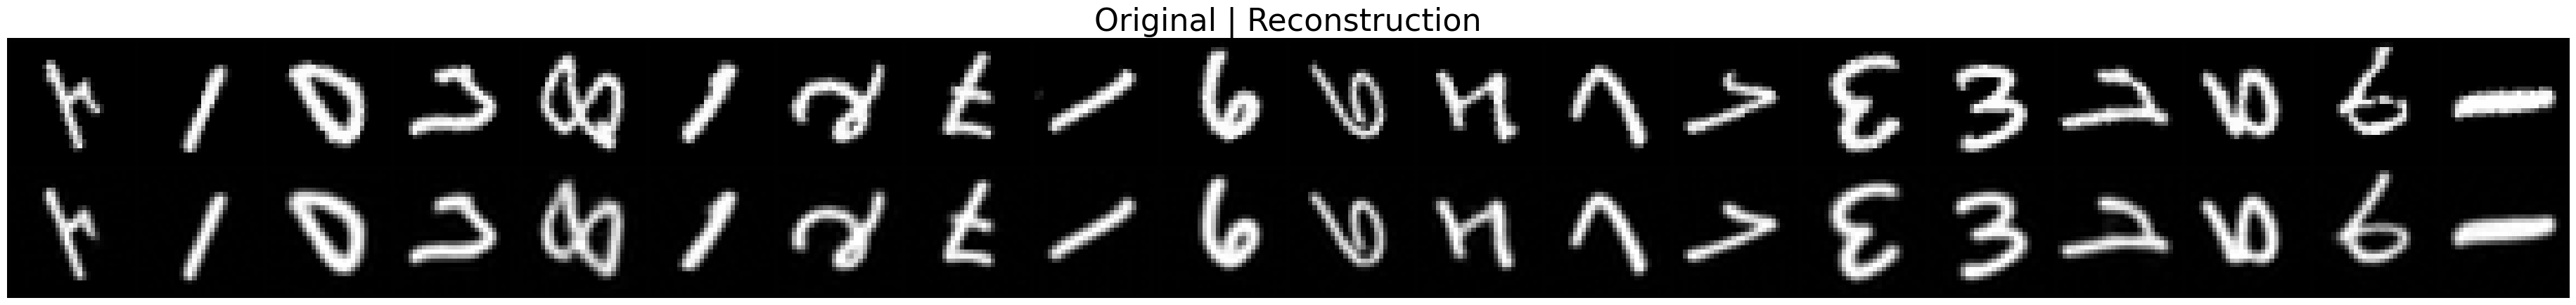

10000/10000 [==============================] - 796s 80ms/step - elbo: 1211.9009 - iwlb: nan - kld: 42.1661 - ll: 1254.0669 - loss: -1211.9009 - x_mse: 0.0133 - elbo_test: 1150.6599 - iwlb_test: nan - kld_test: 42.1940 - ll_test: 1192.8540 - loss_test: -1150.6599 - x_mse_test: 0.0169- elbo: 935.9186 - iwlb: nan - kld: 39.0257 - ll: 974.9445 - loss: -935.9186 - x_mse: 0.0139 - elbo_test: 896.4114 - iwlb_test: nan - kld_test: 39.3394 - ll_test: 935.7509 - loss_test: -896.4114 - x_mse_test:  - ETA: 3:22 - elbo: 936.1807 - iwlb: nan - kld: 39.0380 - ll: 975.2188 - loss: -936.1807 - x_mse: 0.0139 - elbo_test: 896.4114 - iwlb_test: nan - kld_test: 39.3394 - ll_test: 935.7509 - loss_test: -896.4114 - x_mse_test: 0.01 - ETA: 3:22 - elbo: 935.7104 - iwlb: nan - kld: 39.0531 - ll: 974.7635 - loss: -935.7104 - x_mse: 0.0140 - elbo_test: 896.4114 - iwlb_test: nan - kld_test: 39.3394 - ll_test: 935.7509 - loss_test: -896.4114 - x_mse_test: 0.01 - ETA: 3:22 - elbo: 935.7878 - iwlb: nan - kld: 39.0771

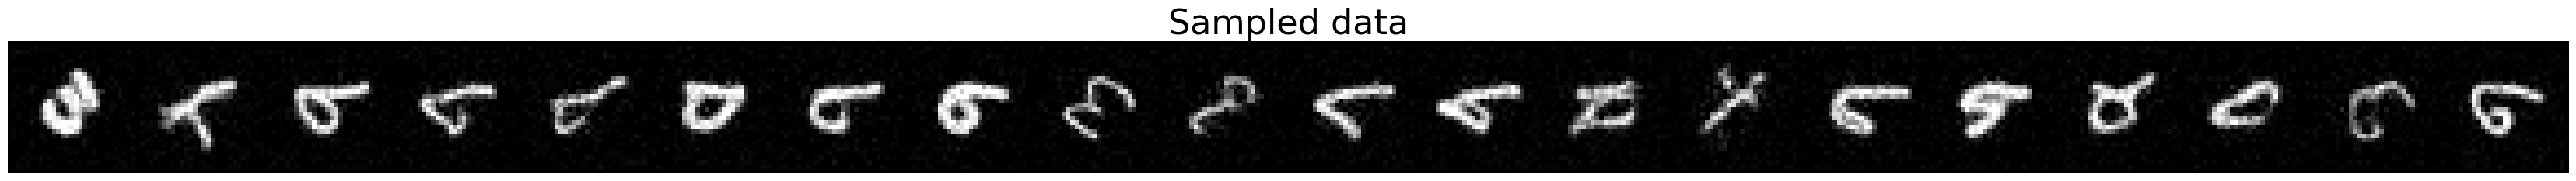

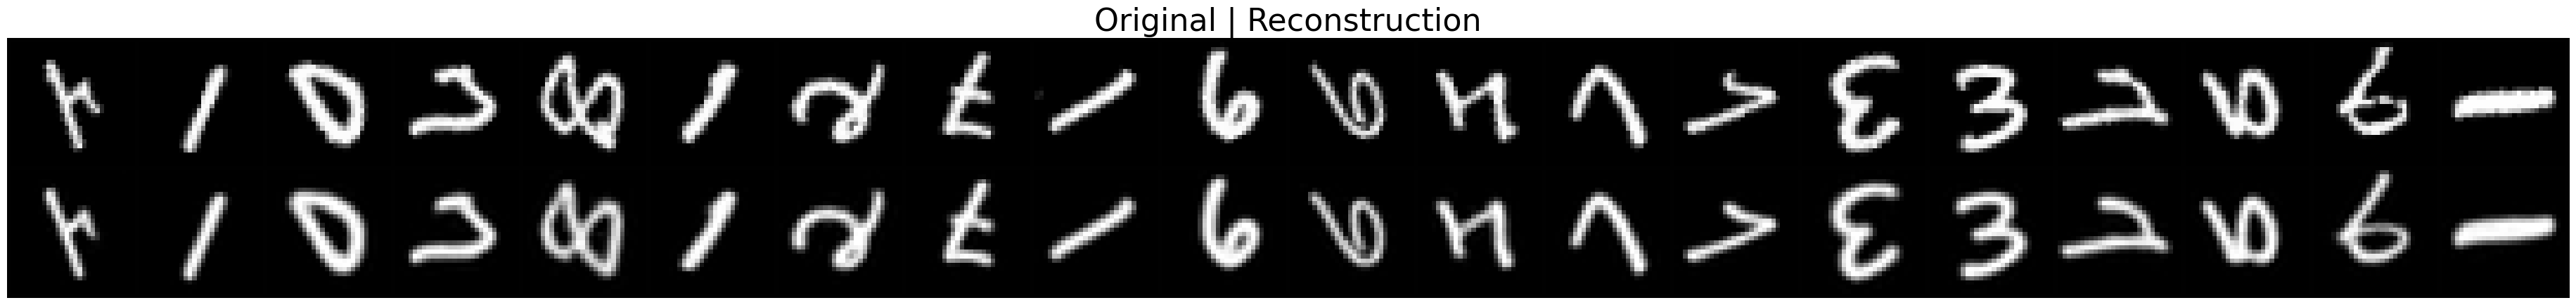

lr,▁▂▄▆███████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂
train/elbo,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
train/kld,▁▁▁▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
train/ll,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████
train/loss,████▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train/x_mse,█▇▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/elbo,▁▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
valid/kld,▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
valid/ll,▁▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
valid/loss,█▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
valid/x_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [19]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=vae_config.to_dict(),
    mode="offline",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

final_inv_vae_state, history, _ = ciclo.train_loop(
    inv_vae_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [train_step],
        ciclo.every(int(vae_config.steps * vae_config.plot_freq)): [
            sampling_plot,
            reconstruction_plot,
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: [
            eval_step,
        ],
        ciclo.every(1): custom_wandb_logger(run=run),
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(vae_config.steps * vae_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=vae_config.steps),
    ],
    stop=vae_config.steps + 1,
)

run.finish()

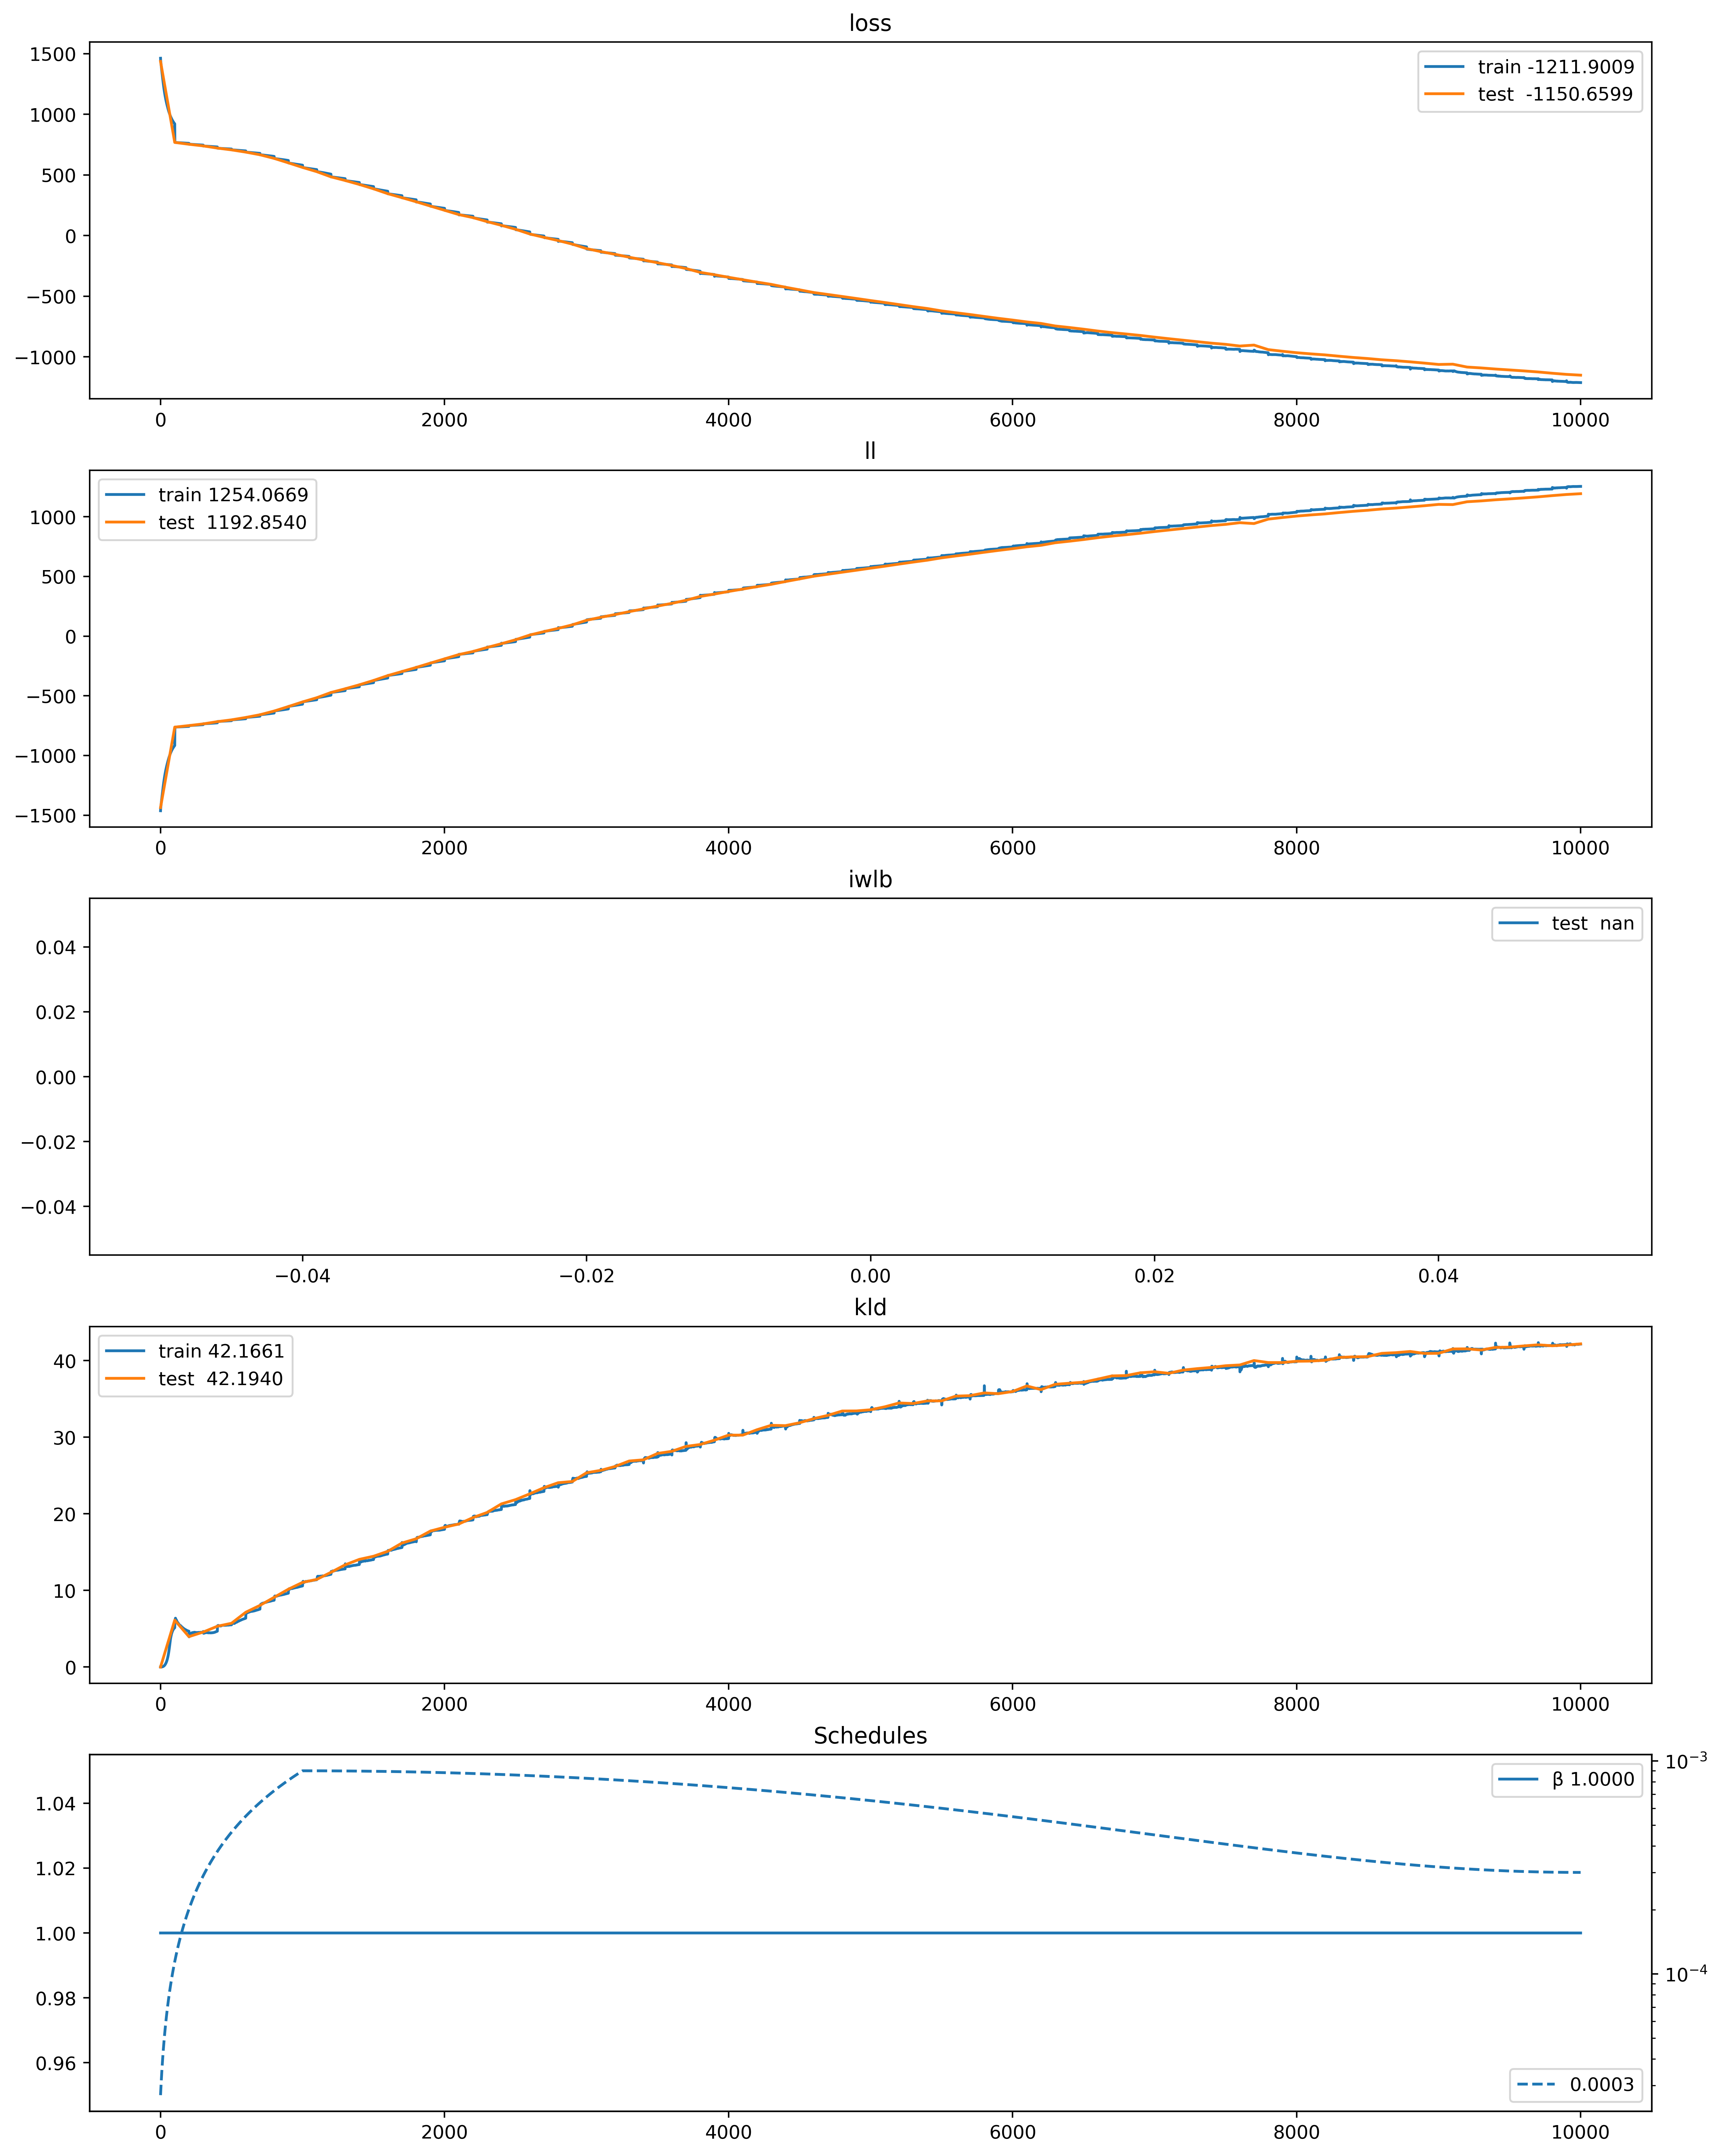

In [20]:
# plot the training history
steps, loss, elbo, ll, kld, lr, β = history.collect(
    "steps", "loss", "elbo", "ll", "kld", "lr", "β"
)
steps_test, loss_test, elbo_test, ll_test, kld_test, iwlb_test = history.collect(
    "steps", "loss_test", "elbo_test", "ll_test", "kld_test", "iwlb_test"
)

n_plots = 5
fig, axs = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots), dpi=400)

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, ll, label=f"train {ll[-1]:.4f}")
axs[1].plot(steps_test, ll_test, label=f"test  {ll_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("ll")

axs[2].plot(steps_test, iwlb_test, label=f"test  {iwlb_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("iwlb")

axs[3].plot(steps, kld, label=f"train {kld[-1]:.4f}")
axs[3].plot(steps_test, kld_test, label=f"test  {kld_test[-1]:.4f}")
axs[3].legend()
axs[3].set_title("kld")

axs[4].plot(steps, β, label=f"β {β[-1]:.4f}")
axs[4].legend()
axs[4].set_title("Schedules")

ax4_twin = axs[4].twinx()
ax4_twin.plot(steps, lr, "--", label=f"{lr[-1]:.4f}")
ax4_twin.legend(loc="lower right")
ax4_twin.set_yscale("log")

plt.show()

In [22]:
vae_config_test = vae_config.copy_and_resolve_references()
vae_config_test.run_iwlb = True
vae_config_test.test_split = "test"

_, _, test_ds = get_data(vae_config_test, data_rng)
_, test_step = make_inv_vae_train_and_eval(inv_vae_model, vae_config_test)

_, test_history, _ = ciclo.test_loop(
    final_inv_vae_state,
    deterministic_data.start_input_pipeline(test_ds),
    {
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: [
            test_step,
        ],
    },
)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image', 'label']):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]', 'label': 'int64[]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='test', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_m

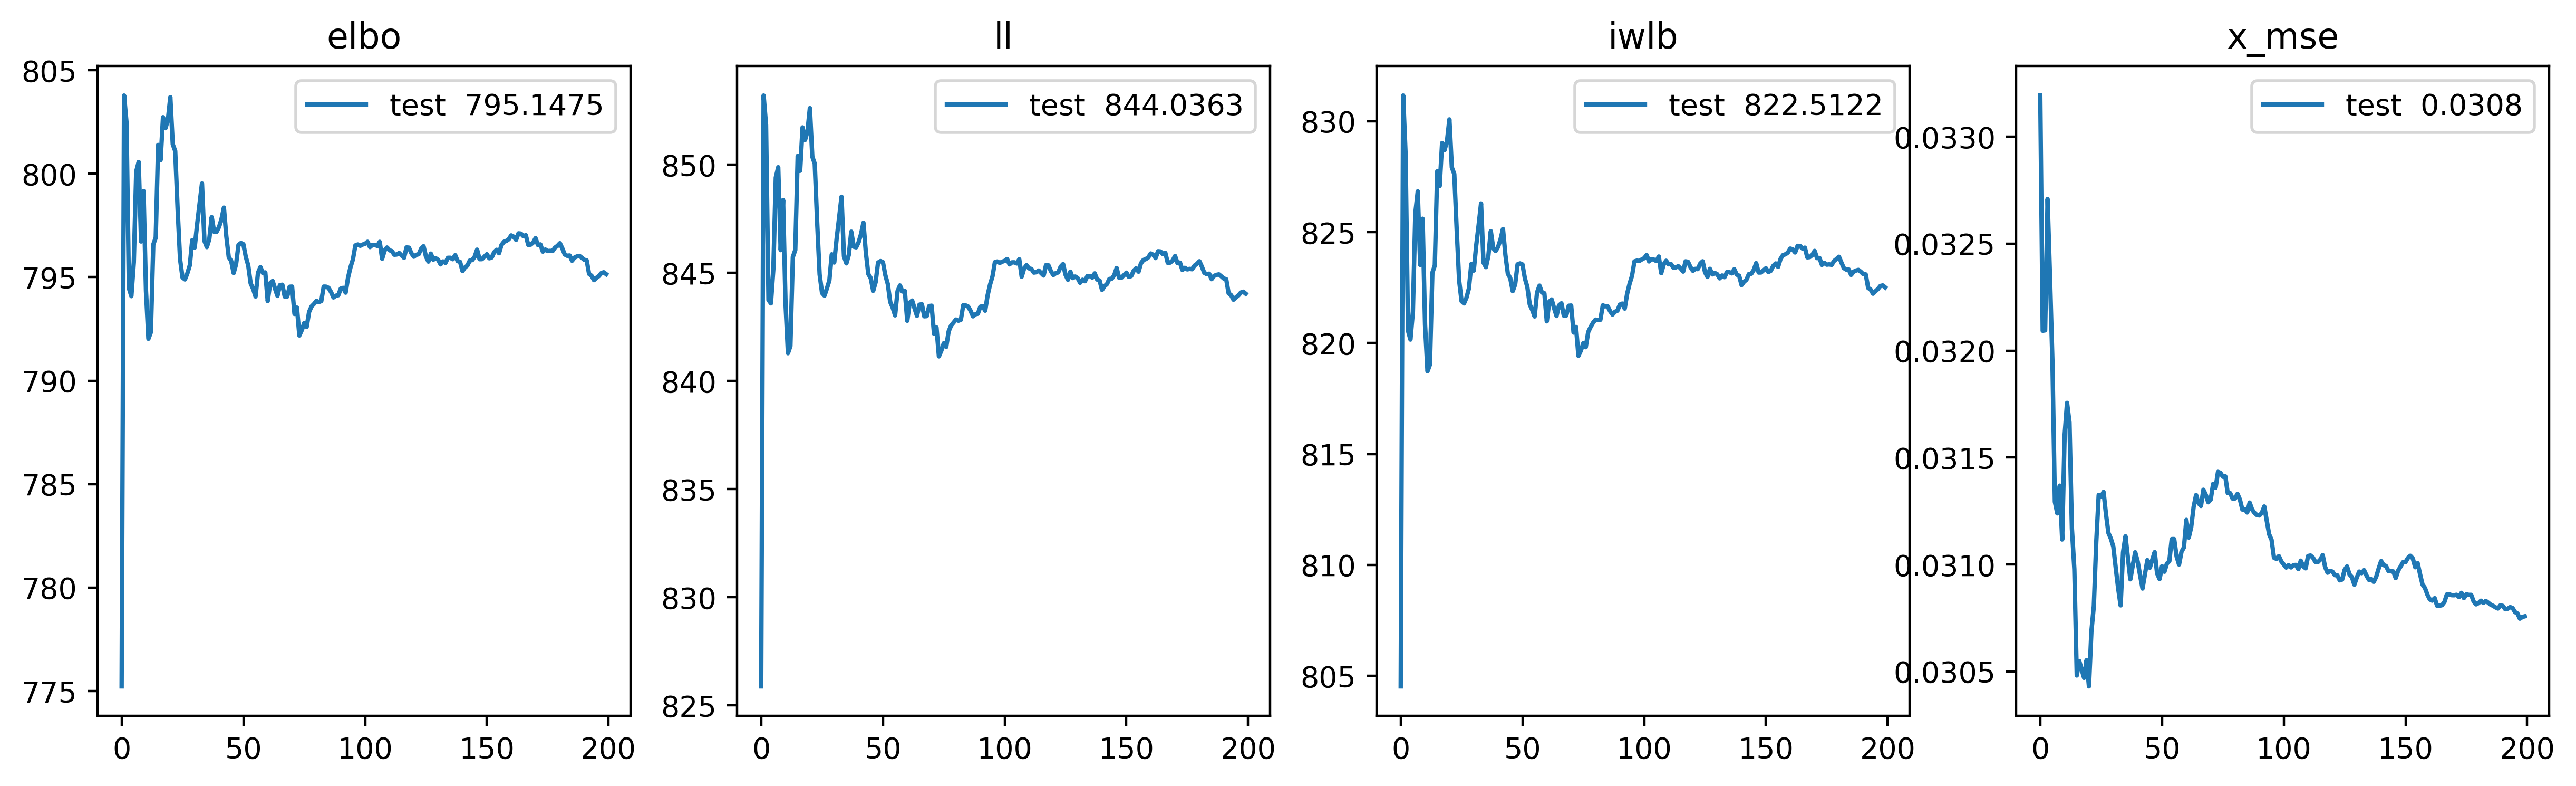

In [ ]:
# make a plot of the test history (specifically the ELBO, ll, iwlb)
steps, elbo, ll, iwlb, x_mse = test_history.collect("steps", "elbo", "ll", "iwlb", "x_mse")

fig, axs = plt.subplots(1, 4, figsize=(15, 4), dpi=400)

axs[0].plot(steps, elbo, label=f"test  {elbo[-1]:.4f}")
axs[0].legend()
axs[0].set_title("elbo")

axs[1].plot(steps, ll, label=f"test  {ll[-1]:.4f}")
axs[1].legend()
axs[1].set_title("ll")

axs[2].plot(steps, iwlb, label=f"test  {iwlb[-1]:.4f}")
axs[2].legend()
axs[2].set_title("iwlb")

axs[3].plot(steps, x_mse, label=f"test  {x_mse[-1]:.4f}")
axs[3].legend()
axs[3].set_title("x_mse")

plt.show()